# Import Libraries

In [2]:
import numpy as np
import cv2
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random,os,glob
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.disable_eager_execution()

from google.colab import drive
drive.mount('/content/drive')

Instructions for updating:
non-resource variables are not supported in the long term
Mounted at /content/drive


## Configuration

In [3]:
IS_MODEL_PRETRAINED = True # if false then model will be trained which takes some time according to number of epocs. If true make sure to upload model h5 file to directory. 

## Dataset Input

In [4]:
dir_path = 'drive/MyDrive/trashnet/dataset-resized'

In [5]:
img_list = glob.glob(os.path.join(dir_path, '*/*.jpg'))


In [6]:
print(os.path.join(dir_path, '*/*.jpg'))

drive/MyDrive/trashnet/dataset-resized/*/*.jpg


In [7]:
print('Total ' + str(len(img_list))  + 'images')

Total 2527images


# Image Augmentation

In [8]:
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

train_generator=train.flow_from_directory(dir_path,
                                          target_size=(300,300),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(dir_path,
                                        target_size=(300,300),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation',
                                        shuffle=False)

labels = (train_generator.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [9]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 300, 300, 3), (32, 6))

### Writing the labels file

In [10]:
print (train_generator.class_indices)

Labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(Labels)


{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


# Building CNN & Saving keras model ( OR Loading pretrained model)

In [11]:
def build_and_train_model(): 
  model=Sequential()
#Convolution blocks

  model.add(Conv2D(32,(3,3), padding='same',input_shape=(300,300,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5)) # No accuracy

  model.add(Conv2D(64,(3,3), padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5))

  model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=2)) 

#Classification layers
  model.add(Flatten())

  model.add(Dense(64,activation='relu'))
#model.add(SpatialDropout2D(0.5))
  model.add(Dropout(0.2))
  model.add(Dense(32,activation='relu'))

  model.add(Dropout(0.2))
  model.add(Dense(6,activation='softmax'))

  filepath="trained_model.h5"
  checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint1]

  #Compiling Model using categorical cross entropy loss function & Adam Optimizer
  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


  #TRAIN
  history = model.fit_generator(train_generator,
                              epochs=78,
                              steps_per_epoch=2276//32,
                              validation_data=test_generator,
                              validation_steps=251//32,
                              workers = 4,
                             callbacks=callbacks_list) 
 #41 epoch - 75% #73- 76.9%
  return model,history



In [12]:
def plot_model_history(history):
 if history is None:
   print("Model pretrained, cannot plot history") 
   return

 acc = history.history['acc']
 val_acc = history.history['val_acc']

 loss = history.history['loss']
 val_loss = history.history['val_loss']

 #________________ Graph 1 -------------------------

 plt.figure(figsize=(8, 8))
 plt.subplot(2, 1, 1)
 plt.plot(acc, label='Training Accuracy')
 plt.plot(val_acc, label='Validation Accuracy')
 plt.legend(loc='lower right')
 plt.ylabel('Accuracy')
 plt.ylim([min(plt.ylim()),1])
 plt.title('Training and Validation Accuracy')

 #________________ Graph 2 -------------------------

 plt.subplot(2, 1, 2)
 plt.plot(loss, label='Training Loss')
 plt.plot(val_loss, label='Validation Loss')
 plt.legend(loc='upper right')
 plt.ylabel('Cross Entropy')
 plt.ylim([0,max(plt.ylim())])
 plt.title('Training and Validation Loss')
 plt.show()

Reference: [Callback model Checkpoint](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)

In [13]:
def loadOrTrainModel(isModelPretrained: bool): 
  if isModelPretrained:
    return keras.models.load_model('drive/MyDrive/trashnet/trained_model(2).h5'),None
  else: 
      return build_and_train_model()


# Summarizing our model

In [14]:
model,history = loadOrTrainModel(IS_MODEL_PRETRAINED)
model.summary()
plot_model_history(history)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 150, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                

# Testing PREDICTION 
##### Note: Path is of training dataset (pl. don't mind)

In [15]:
def load_image_by_name(imageName: str):
  basePath = 'drive/MyDrive/trashnet/dataset-resized/'
  img_path = basePath + imageName
  
  img = image.load_img(img_path, target_size=(300, 300))
  img = image.img_to_array(img, dtype=np.uint8)
  img=np.array(img)/255.0
  return img

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Maximum Probability:  0.9959293
Classified: plastic


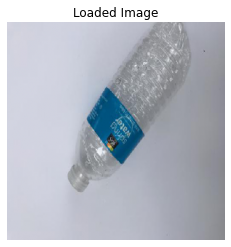

In [16]:
from keras.preprocessing import image
img_name = 'plastic/plastic75.jpg'

img = load_image_by_name(img_name)

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)




-------------------Individual Probability--------------------------------

CARDBOARD : 0.04 %
GLASS : 0.36 %
METAL : 0.0 %
PAPER : 0.0 %
PLASTIC : 99.59 %
TRASH : 0.0 %


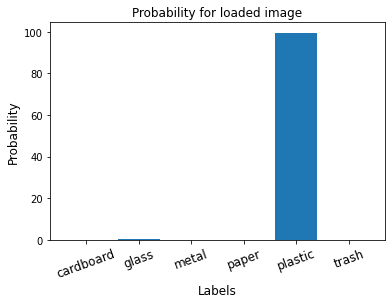

In [17]:
classes=[]
prob=[]
print("\n-------------------Individual Probability--------------------------------\n")

for i,j in enumerate (p[0],0):
    print(labels[i].upper(),':',round(j*100,2),'%')
    classes.append(labels[i])
    prob.append(round(j*100,2))
    
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(classes))
    plt.bar(index, prob)
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)
    plt.title('Probability for loaded image')
    plt.show()
plot_bar_x()

# Accuracy Graph

In [18]:
import matplotlib.image as mpimg
def process(filename: str=None) -> None:
    
    image = mpimg.imread(filename)

    plt.figure()
    plt.imshow(image)

# Defining explainer interface
Next we will try to explain how each of the models "reason" about their predictions. We will be looking at 3 different methods. In order to organize code and better work with their results we will define a common signature each of them should follow.

In [19]:
class ModelExplainerInterface():
    def explain_image_by_image_name(self, image_name: str):
        """Load in the file for extracting text."""
        pass
    
    def explain_image_by_test_data_index(self, generator, index: int):
        """Extract text from the currently loaded file."""
        pass
    
    def load_image_by_image_name( self, image_name: str) :
        img =  load_image_by_name(image_name)
        label_name, label_class  = self.get_class_from_name(image_name)
        return img, label_name, label_class


    def load_image_by_test_data_index(self, generator, test_data_index: int) :
      
      imgs= []
      img_path = 'drive/MyDrive/trashnet/dataset-resized/'
      names = []
      for name in  test_generator.filenames:
        img = image.load_img(img_path+name, target_size=(300, 300,3))
        img = image.img_to_array(img, dtype=np.uint8)

        img=np.array(img)/255.0

        names.append(name)
      imgs.append(img[np.newaxis, ...])

      return imgs,names
    
    def get_class_from_name(self, image_name: str) : 
      label_name = image_name.split('/')[0]
      label_class = list(labels.keys())[list(labels.values()).index(label_name)]
      return label_name, label_class       


# LIME EXPLAINER

In [20]:
!pip install lime
from IPython.display import clear_output 

from keras.preprocessing import image
from skimage.segmentation import mark_boundaries
from lime import lime_image
clear_output()

In [21]:
class LimeModelExplainer(ModelExplainerInterface):
  def explain_image_by_image_name(self, image_name: str):
       img,label_name, label_class  = super(LimeModelExplainer, self).load_image_by_image_name(image_name)
       temp, mask = self.explain_image(img)
       self.plot_explanations(temp,mask)

  def explain_image_by_test_data_index(self, generator, index: int) :
       img  = self.load_image_by_test_data_index(test_generator, index)

       temp, mask = self.explain_image(img)
       self.plot_explanations(temp,mask)
   

  def explain_image(self, img): 

    explainer = lime_image.LimeImageExplainer()


    explanation = explainer.explain_instance(img.astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

    #temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

    return temp_2, mask_2
    

  def plot_explanations(self,temp, mask): 
    fig, ax1 = plt.subplots(1, 1, figsize=(7,7))
    print(mask.shape)
    print(temp.shape)
    plt.title(label='Lime explanation')
    ax1.imshow(mark_boundaries(temp, mask))
    ax1.axis('off')
    



plastic/plastic75.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

(300, 300)
(300, 300, 3)
cardboard/cardboard12.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

(300, 300)
(300, 300, 3)


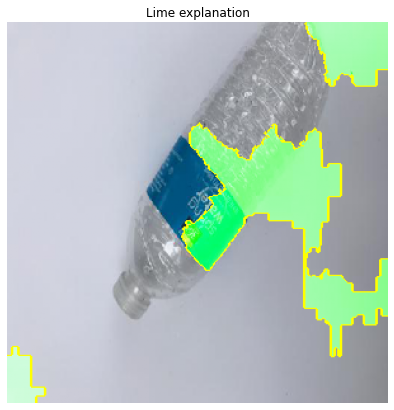

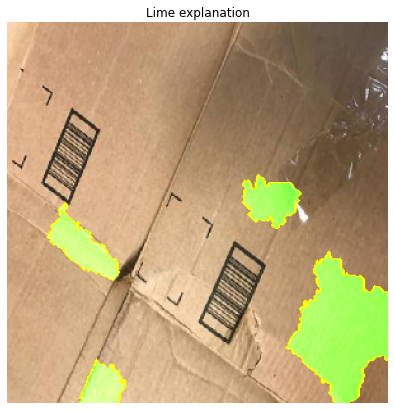

In [22]:
images = ['plastic/plastic75.jpg', 'cardboard/cardboard12.jpg']#, 'glass/glass5.jpg', 'metal/metal20.jpg' ]
LimeExplainer = LimeModelExplainer()
for imgName in images: 
  print(imgName)
  #explain_image(imgName)
  LimeExplainer.explain_image_by_image_name(imgName)


# 2. SHAP - SHapley Additive exPlanations



In [23]:
!pip install shap
import shap
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
import ssl
clear_output()

In [24]:
import matplotlib
class ShapModelExplainer(ModelExplainerInterface):
  def explain_image_by_image_name(self, image_name: str):
       img, label_name, label_class  = super(ShapModelExplainer, self).load_image_by_image_name(image_name)
       img = img[np.newaxis, ...]
       shap_values = self.explain_image(img)

       self.plot_explanations(shap_values,img)

  def explain_image_by_test_data_index(self, generator, index: int) :
       img  = self.load_image_by_test_data_index(test_generator, index)

       temp, mask = self.explain_image(img)
       self.plot_explanations(temp,mask)
   

  def explain_image(self, img): 
    print("Explaining with SHAP")

    background_imgs = self.build_background_for_computing(test_generator)
    
    p=model.predict(img)

     # DeepExplainer to explain predictions of the model

    explainer = shap.DeepExplainer(model, background_imgs)# compute shap values
    shap_values = explainer.shap_values(img, check_additivity= False)

    return shap_values



  def build_background_for_computing(self, generator):     
    background_imgs = []
    for name in  generator.filenames:
      img, label_name, label_class = super(ShapModelExplainer, self).load_image_by_image_name(name)
      background_imgs.append(img[np.newaxis, ...])

    return background_imgs  


  def plot_explanations(self,shap_values, img): 
        shap.image_plot(shap_values, img, labels=list(labels.values()), show=False)
        #plt.title('Shap Explanation')
        plt.show()



Explaining with SHAP


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


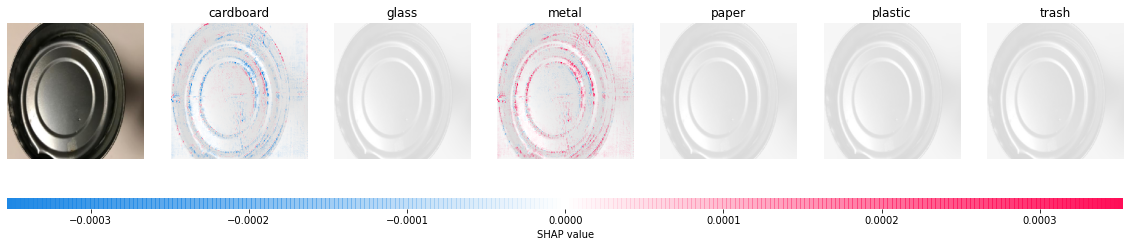

In [25]:

ShapExplainer = ShapModelExplainer()
#ShapExplainer.explain_image_by_image_name("plastic/plastic75.jpg")
#ShapExplainer.explain_image_by_image_name("glass/glass5.jpg")
ShapExplainer.explain_image_by_image_name("metal/metal20.jpg")


# OCCLUSION SENSITIVITY method using tf-explain

In [26]:
!pip install tf-explain
from keras.preprocessing import image
from tf_explain.callbacks.occlusion_sensitivity import OcclusionSensitivity
from skimage.segmentation import mark_boundaries
from lime import lime_image
import cv2
from tf_explain.callbacks.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.callbacks.grad_cam import GradCAM
from PIL import Image

clear_output()

In [128]:
import seaborn as sns
class OcclusionSensitityModelExplainer(ModelExplainerInterface):
  def explain_image_by_image_name(self, image_name: str):
       img, label_name, label_class  = super(OcclusionSensitityModelExplainer, self).load_image_by_image_name(image_name)
       img = img[np.newaxis, ...]
       print(label_class)
       grid, saved_file_name = self.explain_image(img,label_class)

       self.plot_explanations(saved_file_name)

  def explain_image_by_test_data_index(self, generator, index: int) :
       img  = self.load_image_by_test_data_index(test_generator, index)

       temp, mask = self.explain_image(img)
       self.plot_explanations(temp,mask)
   

  def explain_image(self, img, label_class): 
      print("Explaining with Occlusion Sensitivity")
      explainer = OcclusionSensitivity()
      true_label = label_class
      data = (img, true_label)

      explained_img_name = "occlusion_sensitivity.png"
      grid = explainer.explain(data, model, true_label, patch_size=15, colormap=cv2.COLORMAP_TURBO)  # 
      explainer.save(grid, ".", explained_img_name)
      #ax = sns.heatmap(grid,xticklabels=False, yticklabels=False)
      return grid, explained_img_name





  def plot_explanations(self,img_name): 

     img = mpimg.imread(img_name)
     plt.figure(figsize = (6,6))
     imgplot = plt.imshow(img)
     plt.axis('off')
     plt.title('Occlusion Sensitivity')
     plt.show()

In [130]:
OcclusionExplainer = OcclusionSensitityModelExplainer()


1
Explaining with Occlusion Sensitivity


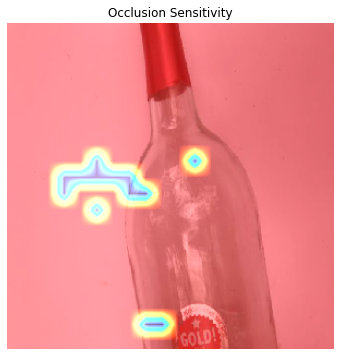

In [131]:
OcclusionExplainer.explain_image_by_image_name('glass/glass103.jpg')

After running one example of occl sensitivity explanation for the glass image above, we notice a couple of unexpected results:


1.   Judging from the tf-explain library's examples and color scale used, red color was expected to denote most important parts of the image, or the parts of the image that are more sensitive to occlusion. However we notice that the whole background is pictured as red.
2.   One of the main use cases for occlusion mapping is to visualize what kind of shapes/patterns model is using for prediction, but there is not any noticeable shape visible in this case.

Let's observe some more examples and try to understand what is going on.



## Examples

4
Explaining with Occlusion Sensitivity


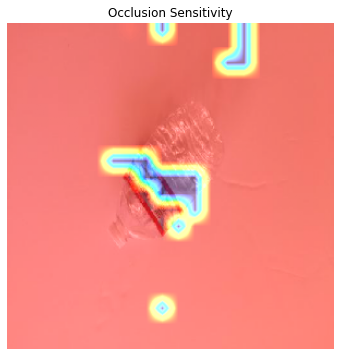

In [132]:
#Example 1
OcclusionExplainer.explain_image_by_image_name('plastic/plastic135.jpg')

0
Explaining with Occlusion Sensitivity


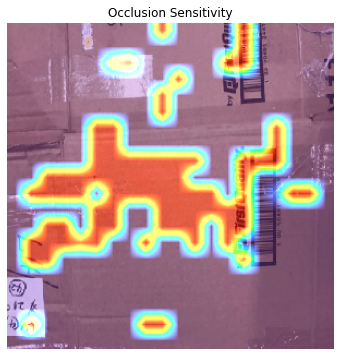

In [133]:
#Example 2 
OcclusionExplainer.explain_image_by_image_name('cardboard/cardboard108.jpg')

0
Explaining with Occlusion Sensitivity


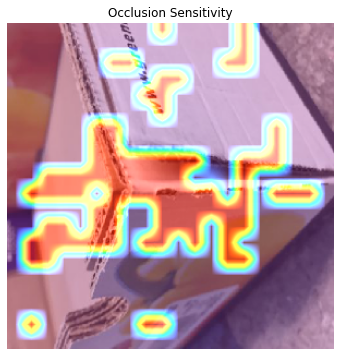

In [134]:
#Example 3 
OcclusionExplainer.explain_image_by_image_name('cardboard/cardboard117.jpg')


Let's try to explain the examples above. 

1. Example 1 predicts a plastic image. Most of the background is still completely red.
2. Example 2 predicts a cardboard. Here we see that most of the background is looking blue ( not important) except of the red part which would mean important parts. Maybe it is able to correctly explain cardboard images?
3. Example 3 is still a cardboard picture. From the first glance both 2 cardboards look very different from each other. However strangely both heatmap  overlayed on the picture look extremely similar shaped. 

Let's try to explain another plastic image and contrasting with the first example.

4
Explaining with Occlusion Sensitivity


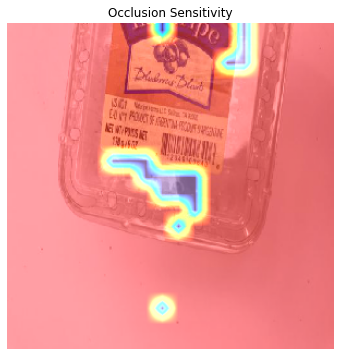

In [52]:
#Example 4
OcclusionExplainer.explain_image_by_image_name('plastic/plastic108.jpg')

Comparing example #4 with example #1 also validates our assumption. Both heatmaps are extremely similar even though images are very different from each other. Seems heatmaps are generalized for the whole class

## Conclusion about tf-explain
Something is strange in our OcclusionSensitivity explainer which uses the tf-explain library. Results are not as expected. It could be a bug in our code, or a bug with the library. We could either try to find out what is wrong, or try a simple, raw implementation of occlusion sensitivity based on other sources. We will follow the second approach.

# Second Occlusion sensitivity implementation ( RAW implementation mostly based on https://github.com/oswaldoludwig/Sensitivity-to-occlusion-Keras-)

In [ ]:
#imports
from seaborn import palettes
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy
import math
import pylab
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from numpy.random import permutation
from google.colab.patches import cv2_imshow


In [84]:
# simple function to perform occlusion sensitivity on a  speicific picture
def explain_occ_sensitivity_raw(occluding_size, occluding_pixel, occluding_stride, image_name):

    im_path = dir_path + image_name
    
    original_resized_image = load_image_by_name(image_name)
    
    # im = im.transpose((2, 0, 1))
    plt.imshow(original_resized_image.squeeze())
    
    im = original_resized_image[np.newaxis, ...]
    #print(im.shape)
    
    out = model.predict(im)
    #print('predicted first')
    #print(out)
    out = out[0]
    #print(out)
    # Getting the index of the winning class:
    m = max(out)

    index_object = [i for i, j in enumerate(out) if j == m]
    
    height, width, _ = original_resized_image.shape

    output_height = int(math.ceil((height - occluding_size) / occluding_stride + 1))
    output_width = int(math.ceil((width - occluding_size) / occluding_stride + 1))
    heatmap = np.zeros((output_height, output_width))
    print(heatmap.shape)
    for h in range(output_height):
        for w in range(output_width):
            # Occluder region:
            h_start = h * occluding_stride
            w_start = w * occluding_stride
            h_end = min(height, h_start + occluding_size)
            w_end = min(width, w_start + occluding_size)
            # Getting the image copy, applying the occluding window and classifying it again:
            input_image_original = np.copy(original_resized_image)
            input_image_original[h_start:h_end, w_start:w_end] = occluding_pixel
            im = input_image_original[np.newaxis, ...]
            #plt.imshow(input_image_original.squeeze())
            #plt.show()
    
            # im = im.transpose((2, 0, 1))
            out = model.predict(im)
            # print(out)
            out = out[0]
            #print('scanning position (%s, %s)' % (h, w))
            # It's possible to evaluate the VGG-16 sensitivity to a specific object.
            # To do so, you have to change the variable "index_object" by the index of
            # the class of interest. The VGG-16 output indices can be found here:
            # https://github.com/HoldenCaulfieldRye/caffe/blob/master/data/ilsvrc12/synset_words.txt
            prob = (out[index_object])
            heatmap[h, w] = 1 - prob
            # print(prob)
    
    f = pylab.figure()
    f.add_subplot(1, 2, 1)  # this line outputs images side-by-side   
    # palet = sns.color_palette("Spectral", n_colors=15)
    # palet.reverse()
    
    ax = sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
    f.add_subplot(1, 2, 1)
    plt.imshow(original_resized_image)
    plt.show()
    print('Object index is %s' % index_object)

## Examples

At example #1 below we try to explain a glass bottle using the raw occl sensitivity implementation. Now we really are starting to see the shape of the bottle of wine in the generated heatmap. This part of the image is denoted with high values and in turn with very bright spots ( due to the color scheme selection). This happens because in our implementation we are using 1-proba to fill the heatmap values. 

I.e Blocking the center part of the image which corresponds to the bottle caused a very low probability of prediction for the glass class. Doing 1-that value would result in a high value and a bright spot.

(51, 51)


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


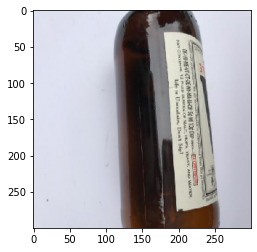

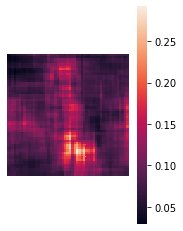

Object index is [1]


In [101]:
#Example 1
occluding_size = 50
occluding_pixel = 0.5
occluding_stride = 5
emri ='glass/glass107.jpg'
explain_occ_sensitivity_raw(occluding_size, occluding_pixel, occluding_stride, emri)


Below we see the explanations generated from predicting some piece of metal. The circular shape of the metal in the original image somehwat matches the pixels in the heatmap. 

(55, 55)


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


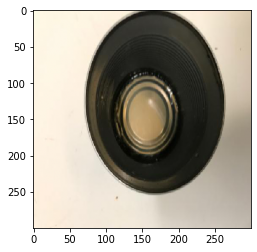

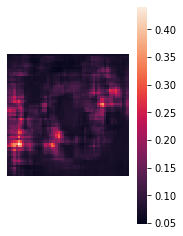

Object index is [2]


In [119]:
#Example 2
occluding_size = 30
occluding_pixel = 0.5
occluding_stride = 5
emri ='metal/metal127.jpg'
explain_occ_sensitivity_raw(occluding_size, occluding_pixel, occluding_stride, emri)


(51, 51)


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


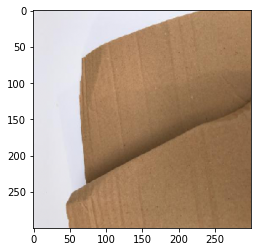

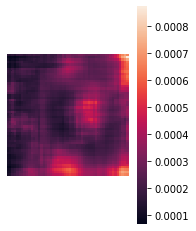

Object index is [0]


In [127]:
#Example 3
occluding_size = 50
occluding_pixel =0.5
occluding_stride = 5
emri ='cardboard/cardboard109.jpg'
explain_occ_sensitivity_raw(occluding_size, occluding_pixel, occluding_stride, emri)


(51, 51)


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


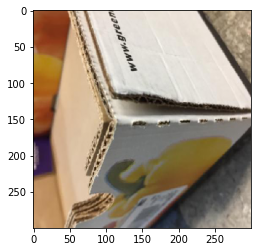

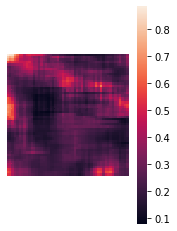

Object index is [0]


In [126]:
#Example 1
occluding_size = 50
occluding_pixel = 0.5
occluding_stride = 5
emri ='cardboard/cardboard117.jpg'
explain_occ_sensitivity_raw(occluding_size, occluding_pixel, occluding_stride, emri)


(55, 55)


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


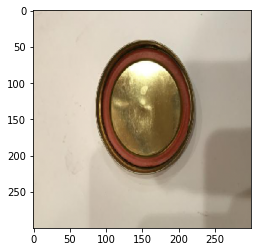

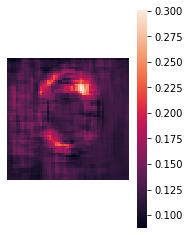

Object index is [2]


In [163]:
#Example 1
occluding_size = 30
occluding_pixel = 0.5
occluding_stride = 5
emri ='metal/metal119.jpg'
explain_occ_sensitivity_raw(occluding_size, occluding_pixel, occluding_stride, emri)


## Validation

Now let's try to purposely try to occlude a part of an image which the explanation deems as important. It is expected that the probability of prediction should drop. Vice versa, blocking some unimportant part of the image should increase or at least not change the proba.

In [ ]:
# utility to occlude images

def get_occluded_image(h_start,w_start,occluding_size, occluding_pixel, occluding_stride, original_image) :
  h_start = h_start * occluding_stride
  w_start = w_start * occluding_stride
  h_end = min(300, h_start + occluding_size)
  w_end = min(300, w_start + occluding_size)
  copy = np.copy(original_image)
  copy[h_start:h_end, w_start:w_end,:] =  occluding_pixel       
  return copy
  
def get_accuracy(img,model):
   p=model.predict(img[np.newaxis, ...])
   proba = np.max(p[0], axis=-1)
   print("Maximum Probability: ",proba)
   return proba
   
     

Let's use the wine bottle example for this. We will try to block an important part of the image right in the center of the bottle with a 50pixel white block. **Notice that probability droped from 92% to 87%.**

(51, 51)


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


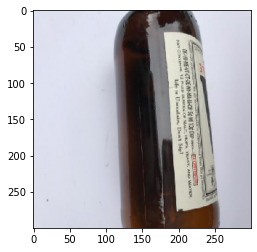

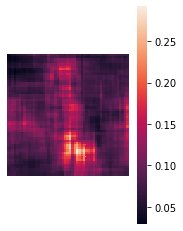

Object index is [1]


In [108]:
explain_occ_sensitivity_raw(occluding_size, occluding_pixel, occluding_stride, emri)

Maximum Probability:  0.9260959
Maximum Probability:  0.8771064
Before: 0.9260959
 After:0.8771064


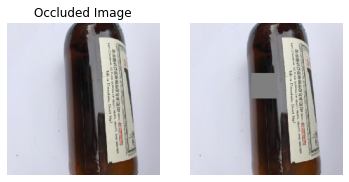

In [109]:
from keras.preprocessing import image
img_name = 'glass/glass107.jpg'
h_start=5
w_start=6
img = load_image_by_name(img_name)

accuracyBeforePlastic = get_accuracy(img, model)
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 
plt.axis('off')

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img.squeeze())
axarr[0].axis('off')
axarr[0].set_title('Original Image')

plt.axis('off')
occluding_size = 50
occluding_pixel = 0.5
occluding_stride = 20
occluded = get_occluded_image(h_start,w_start,occluding_size, occluding_pixel, occluding_stride, img)
axarr[1].imshow(occluded.squeeze())
axarr[1].axis('off')
axarr[0].set_title('Occluded Image')
accuracyAfterPlastic = get_accuracy(occluded, model)
print("Before: " + str(accuracyBeforePlastic)+"\n After:" + str(accuracyAfterPlastic))

occluding_size = 50
occluding_pixel = 0.5
occluding_stride = 5
emri ='glass/glass107.jpg'


We will try to block an unimportant part of the image mostly background which doesn't contain any information for the model. **Notice that probability increased from  92.60% to 95.3%.**

Maximum Probability:  0.9260959
Maximum Probability:  0.9532404
Before: 0.9260959
 After:0.9532404


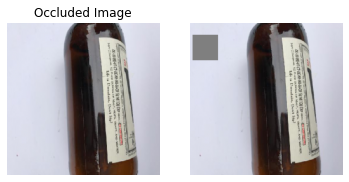

In [111]:
from keras.preprocessing import image
img_name = 'glass/glass107.jpg'
h_start=5
w_start=1
img = load_image_by_name(img_name)

accuracyBeforePlastic = get_accuracy(img, model)
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 
plt.axis('off')

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(img.squeeze())
axarr[0].axis('off')
axarr[0].set_title('Original Image')

plt.axis('off')
occluding_size = 50
occluding_pixel = 0.5
occluding_stride = 5
occluded = get_occluded_image(h_start,w_start,occluding_size, occluding_pixel, occluding_stride, img)
axarr[1].imshow(occluded.squeeze())
axarr[1].axis('off')
axarr[0].set_title('Occluded Image')
accuracyAfterPlastic = get_accuracy(occluded, model)
print("Before: " + str(accuracyBeforePlastic)+"\n After:" + str(accuracyAfterPlastic))

occluding_size = 50
occluding_pixel = 0.5
occluding_stride = 5
emri ='glass/glass107.jpg'


## Interesting finding from occlusion sensitivity

One interesting finding that we had when running different examples of occl sensitivity was the fact that the model is depending a lot on the colors of the objects to make its prediction. More concretely we noticed that the color of the mask really changes the heatmap generated by the explainor. This could be an indicator of model overfitting , which is very possible with this little amount of data (around 2000 for training).

Example generated when using a black mask. Black corresponds to the color of the reflection in the whine glass. Doing this the model doesn't observe some dropp on the proba. As a result we cannot understand anything from the explanation.

(51, 51)


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


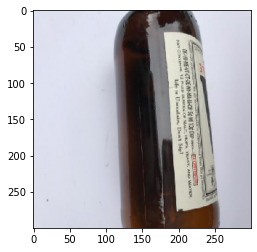

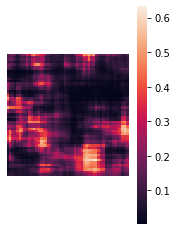

Object index is [1]


In [113]:
#Example 1
occluding_size = 50
occluding_pixel = 0 # 0,0,0 RGB = black
occluding_stride = 5
emri ='glass/glass107.jpg'
explain_occ_sensitivity_raw(occluding_size, occluding_pixel, occluding_stride, emri)


On the other side making the mask color as white, we still discriminate, because we barely change the background by the occlusion ( almost as we have no occlusion at all). However the part of the wine changes drastically from black to white, which explains increased sensitivity and very bright heatmap on that part of the image.

(51, 51)


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


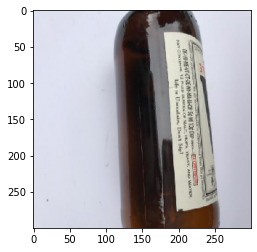

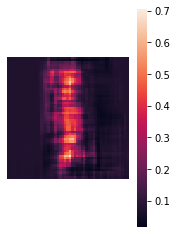

Object index is [1]


In [114]:
#Example 1
occluding_size = 50
occluding_pixel = 1 # 255,255,255 = white
occluding_stride = 5 
emri ='glass/glass107.jpg'
explain_occ_sensitivity_raw(occluding_size, occluding_pixel, occluding_stride, emri)


This explains the reason why most implementations of occl sensitivity use the grey color, as a way to find some middle/more neutral color, as to not discriminate to much in the image. However what happens when the background is grey?

## Conclusion for occlusion sensitivity on our model.

To conclude occlusion sensitivity helped us to have some interesting findings. The mask that we use for occlusion can really impact the heatmap generated for our model. There could be many reasons for this:
1. Model could be overfitted due to not enough data.
2. Model could be overfitted due to noise in data, many pictures have just a very big single color background and the trash placed in the middle.
3. Or maybe this method doesn't make sense to use for our dataset.
4. Best bet we have is to use grey mask which could ruin explanations for very grey backgrounds, or very grey objects.

# Comparing 3 methods

In [165]:
class ExplainerComparator :
  def __init__(self, model, LimeExplainer, ShapExplainer, OcclusionExplainer ): # constructor method
        print('Constructor invoked')
        self.ShapExplainer = ShapExplainer
        self.LimeExplainer = LimeExplainer
        self.OcclusionExplainer = OcclusionExplainer
        self.model = model
  
  def plot_all(self, image_name: str): 

      print("Explaining image with name "+ image_name + '\n')
      print("Explaining with LIME")
      self.LimeExplainer.explain_image_by_image_name(image_name)
      
      print("Explaining with SHAP")
      self.ShapExplainer.explain_image_by_image_name(image_name)
      
      print("Explaining with Occlusion sensitifity")
      #self.OcclusionExplainer.explain_image_by_image_name(image_name)

      explain_occ_sensitivity_raw(occluding_size, occluding_pixel, occluding_stride, image_name)
     

In [145]:
explainer_comparator = ExplainerComparator(model, LimeExplainer, ShapExplainer, OcclusionExplainer)


Constructor invoked


Explaining image with name metal/metal11.jpg

Explaining with LIME


  0%|          | 0/1000 [00:00<?, ?it/s]

(300, 300)
(300, 300, 3)
Explaining with SHAP
Explaining with SHAP


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


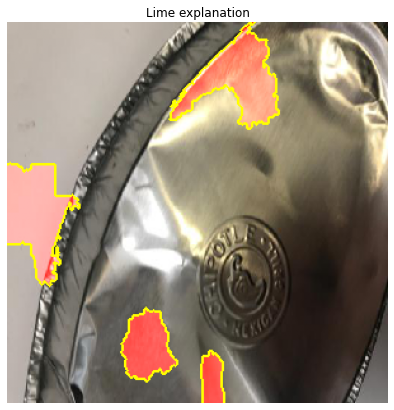

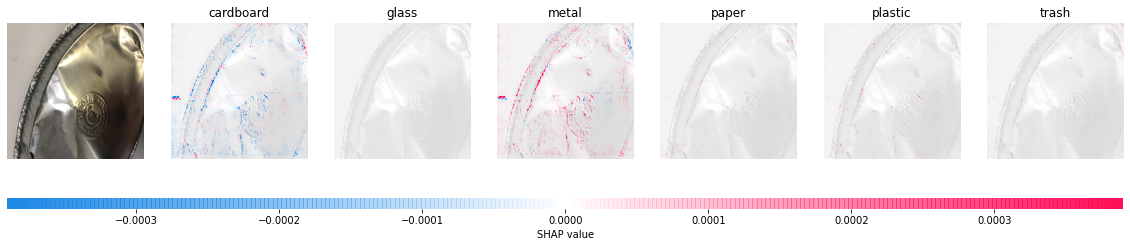

Explaining with Occlusion sensitifity
2
Explaining with Occlusion Sensitivity


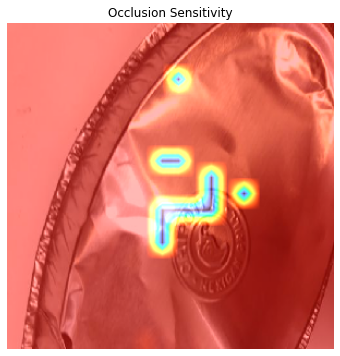

(55, 55)


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


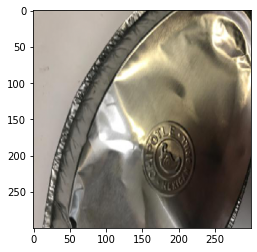

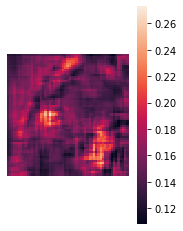

Object index is [2]


In [164]:
images = ['metal/metal11.jpg']#, 'cardboard/cardboard117.jpg']#, 'glass/glass5.jpg', 'metal/metal20.jpg' ]

for img in images:
  explainer_comparator.plot_all(img)
